# Beamforming Testing

Default and nonconfigurable ADC sampling frequency is 4915.2 MHz
Default ADC mixing frequency is 1228.8 MHz
ADC MixerSettings with both mixers bypassed:  {'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 16, 'MixerMode': 4, 'FineMixerScale': 1, 'MixerType': 1}
Measured peak 2 peak amplitude: ? V
Measured frequency: ? MHz
Measured period: ? ns
Phase differences: ????


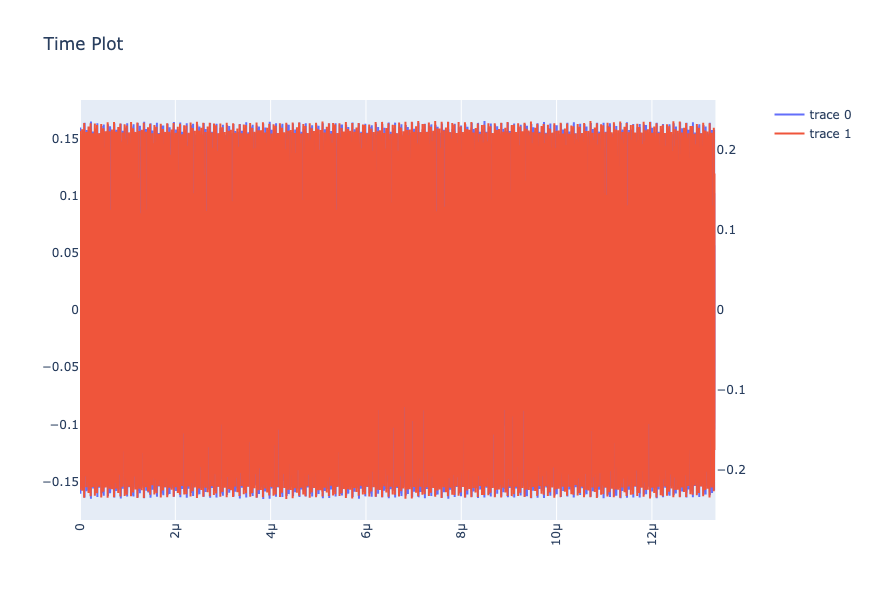

In [29]:
# Imports
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import ipywidgets as ipw
import base64
from random import randint
from pynq import Clocks
import xrfdc
import os
# Use the RFSoC overlay
from pynq.overlays.base import BaseOverlay

base = BaseOverlay('base.bit')

# Start RF clocks
base.init_rf_clks()

# Channels
#print("Transmitter channels:\n",base.radio.transmitter.get_channel_description())
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}

#print("Receiver channels:\n",base.radio.receiver.get_channel_description())
ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1}
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0}
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1}

# Set the center frequency and sampling frequency

print("Default and nonconfigurable ADC sampling frequency is 4915.2 MHz")
print("Default ADC mixing frequency is 1228.8 MHz")

# unused center_frequency = 1240e6  # Hz Frequency of carrier signal
number_samples = 32768  # Between 16 and 32768
decimation_factor = 2 # 2 is default
sample_frequency = 4915.2e6/decimation_factor  # Hz The default sample frequency is 4915.2e6 Hz which is sufficient for our signal

temp = base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings
# print("Default ADC MixerSettings: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)
# print("Default ADC DecimationFactor: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.DecimationFactor)

# help(base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.PwrMode)

for ADC in range(0,len(base.radio.receiver.channel)):
# for ADC in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    base.radio.receiver.channel[ADC].adc_block.DecimationFactor = decimation_factor
    base.radio.receiver.channel[ADC].adc_block.MixerSettings = {
        'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
        'EventSource':    xrfdc.EVNT_SRC_TILE, 
        'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
        'Freq':           0.0,
        'MixerMode':      xrfdc.MIXER_MODE_R2R,
        'MixerType':      xrfdc.MIXER_TYPE_COARSE,
        'PhaseOffset':    0.0
    }
    base.radio.receiver.channel[ADC].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
    # base.radio.receiver.channel[ADC].adc_tile.SetupFIFO(True)
    
# Print mixer settings needed to inspect carrier
print("ADC MixerSettings with both mixers bypassed: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)

# Function to plot real and imaginary data in time domain
def plot_complex_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

def plot_complex_spectrum(data, N=number_samples, fs=sample_frequency, 
                          title='Complex Spectrum Plot', units='dBW', fc=0):
    plt_temp = (go.Scatter(x = np.arange(-fs/2, fs/2, fs/N) + fc,
                           y = data, name='Spectrum'))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Frequency (Hz)',
                                         'autorange': True},
                                     'yaxis': {
                                         'title': units}})


def plot_time(data, n, fs=sample_frequency, 
                      title='Time Plot'):
    plt_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data)))
    return plt_temp
    # return go.FigureWidget(data = plt_temp,
    #                        layout = {'title': title, 
    #                                  'xaxis': {
    #                                      'title': 'Seconds (s)',
    #                                      'autorange' : True},
    #                                  'yaxis': {
    #                                      'title': 'Amplitude (V)'}})

# Functions
# Function to convert integer to binary array
def int_to_binary_array(num, num_bits):
    return np.array(list(format(num, f'0{num_bits}b')), dtype=int)

# Function to convert binary array to integer
def binary_array_to_int(binary_array):
    return int(''.join(map(str, binary_array)), 2)

# Function to generate message with buffer
def _create_buffer(data=np.array([72, 101, 108, 108, 111,  32,  87, 111, 114, 108, 100,  33], dtype=np.uint8), eof=1, padding=0):
        """Create a buffer that is loaded user data. Append the Extended Barker sequence
        to the user data and then pad with zeros
        """
        frame_number = 0
        random_size = 10
        flags = eof
        if data.size == 0:
            raise ValueError('Message size should be greater than 0.')
        msg = np.array(data, dtype=np.uint8)
        # Append Barker and Random Data
        bkr = np.array([0, 0, 63, 112, 28, len(msg) + 5, frame_number, flags, 5, len(msg), padding], dtype=np.uint8)
        rnd = np.array([randint(0, 255) for p in range(0, random_size)], dtype=np.uint8)
        seq = np.append(bkr, msg)
        seq = np.append(rnd, seq)
        pad = np.append(seq, np.zeros(int(np.ceil((len(rnd) + len(bkr) + len(msg))/32) * 32 - (len(rnd) + len(bkr) + len(msg))), dtype=np.uint8))
        buf = allocate(shape=(len(pad),), dtype=np.uint8)
        buf[:] = pad[:]
        return buf
    
def plot_complex_time_multiple(data, data1, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    plt_re_temp1 = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data1), name='Real'))
    plt_im_temp1 = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data1), name='Imag'))
    return go.FigureWidget(data = [[plt_re_temp, plt_im_temp], [plt_re_temp1, plt_im_temp1]],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})
    
    
# Sample carrier signal

carrier_data = []  # Storage for incoming real data
# for ADC in range(0, len(base.radio.receiver.channel)): # Show all plots
for ADC in range(0, ADC_CHANNEL_D+2): # Show only ADC D
    carrier_data.append(base.radio.receiver.channel[ADC].transfer(number_samples))
    
# Plotting raw data in the time domain
figs = [] # Storage for ADC time domain plots

# Add plots to figs
# for ADC in range(0, len(base.radio.receiver.channel)): # Show all plots
for ADC in range(0, ADC_CHANNEL_D+2): # Show only ADC D
    figs.append(plot_time(
        data=carrier_data[ADC], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(ADC), ' Carrier Signal'])))
        
    
# WHAT SHOULD EACH GRAPH LOOK LIKE? MEASURE ON SCOPE FIRST AND COMPARE THESE GRAPHS TO THOSE MEASUREMENTS
# Scope Measurements
# print("Measured peak 2 peak amplitude: ?")
# print("Measured frequency: ? GHz")
# print("Measured period: ? ns")
# print("Phase differences: ????")

print("Measured peak 2 peak amplitude: ? V")
print("Measured frequency: ? MHz")
print("Measured period: ? ns")
print("Phase differences: ????")

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(figs[0])
fig.add_trace(figs[1],secondary_y=True)
fig['layout'].update(height = 600, width = 800, title = 'Time Plot',xaxis=dict(
      tickangle=-90
    ))
fig.show()
# plot ADC real time domain data
# ipw.VBox(figs)